# Table Length Measurements

Python program for analysing measurements of the length of the lecture table in Auditorium A at NBI.  
There are two measurements each with estimated error of the table length:
1. Measurement with a 30cm ruler.
2. Measurement with a 2m folding ruler.

Each person was asked not only to state the measurement, but also their estimated uncertainty. None of the persons could see others measurements in order to get the largest degree of independence. Also, the 30cm ruler measurement was asked to be done first. Finally, those measuring were asked to try to measure to the mm, even if precision was less than this.

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 19-11-2020 (latest update)

***

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys
from scipy import stats
from scipy.special import erfc                         # Error function, to get integral of Gaussian

sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Options for the program: 

In [3]:
blinded = False            # Add a random (but fixed) offset to the 30cm and 2m data seperately
save_plots = False

r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

## Functions:

A Gaussian PDF (unit integral):

In [4]:
# Define your PDF / model 
def gauss_pdf(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)

Extended Gaussian PDF (including normalisation, which enables fit to histograms):

In [5]:
def gauss_extended(x, N, mu, sigma) :
    """Non-normalized Gaussian"""
    return N * gauss_pdf(x, mu, sigma)

In [6]:
def gauss_2(x, N1, mu1, sigma1, N2, mu2, sigma2) :
    """Non-normalized Gaussian"""
    return N1 * gauss_pdf(x, mu1, sigma1) + N2 * gauss_pdf(x, mu2, sigma2)

In [7]:
def gauss_3(x, N1, mu1, sigma1, N2, mu2, sigma2, N3, mu3, sigma3) :
    """Non-normalized Gaussian"""
    return N1 * gauss_pdf(x, mu1, sigma1) + N2 * gauss_pdf(x, mu2, sigma2) + N3 * gauss_pdf(x, mu3, sigma3)

## Initial data analysis:

Before we even look at the look at the data, we decide whether or not we want to blind the analysis by adding a constant to all measurements:


In [8]:
if blinded:
    blinding30cm = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
    blinding2m   = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
else:
    blinding30cm = 0
    blinding2m = 0
    

Define what datafiles we want to look at. Extend it to suit your analysis: 

In [9]:
infiles = ["data_TableMeasurements2020.txt",
           "data_TableMeasurements2019.txt",
           "data_TableMeasurements2018.txt",
           "data_TableMeasurements2017.txt",
           "data_TableMeasurements2016.txt",
           "data_TableMeasurements2015.txt",
           "data_TableMeasurements2014.txt",
           "data_TableMeasurements2013.txt",
           "data_TableMeasurements2012.txt",
           "data_TableMeasurements2011.txt",
           "data_TableMeasurements2010.txt",
           "data_TableMeasurements2009.txt"]

We read in all the data from the `infiles` files:

In [10]:
L30cm = np.array([])
eL30cm = np.array([])
L2m = np.array([])
eL2m = np.array([]) # why numpy arrays, lists are faster to append to, right?

# Loop over files and open them
for infile in infiles:
    
    tmp_L30cm, tmp_eL30cm, tmp_L2m, tmp_eL2m = np.loadtxt(infile, skiprows=2, unpack=True)
    
    L30cm = np.append(L30cm, tmp_L30cm + blinding30cm)
    eL30cm = np.append(eL30cm, tmp_eL30cm)
    L2m = np.append(L2m, tmp_L2m + blinding2m)
    eL2m = np.append(eL2m, tmp_eL2m)
    
N_read  = len(L30cm)       # Number of measurements read in total

#print(L2m)

print(f"\n\nRead all {len(infiles)} file(s) which included {N_read} measurements. \n")



Read all 12 file(s) which included 711 measurements. 



Now we plot the data. Using an interactive plotting style could be useful here.

/Users/nikki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


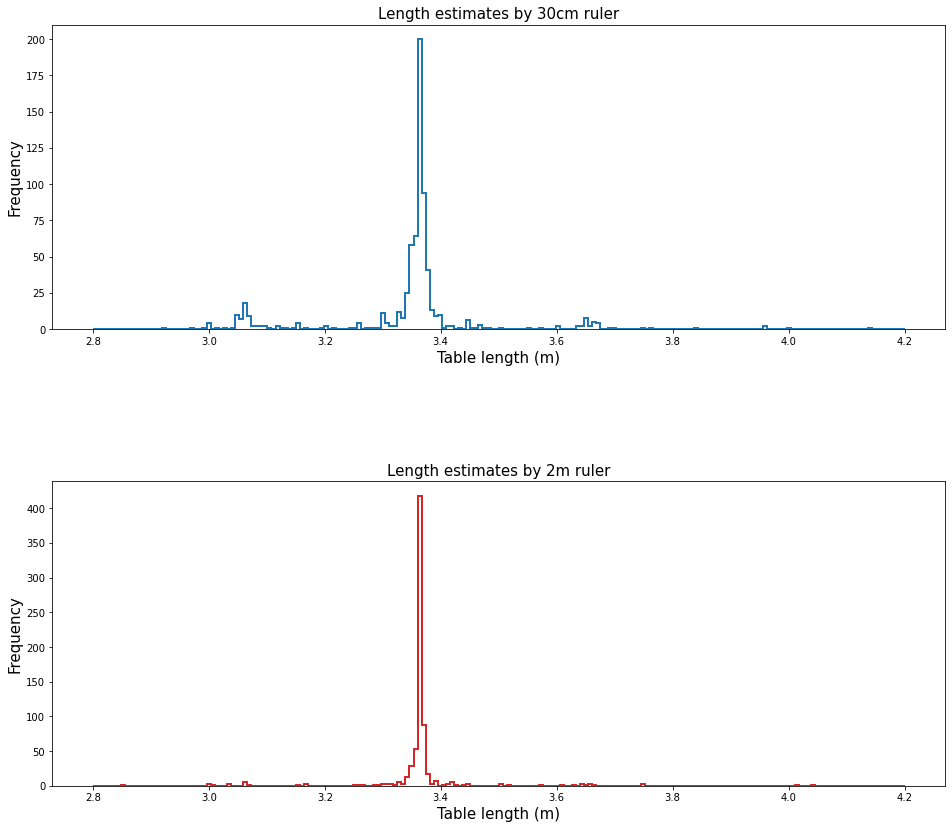

In [11]:
# Carefully consider binning - this might have to be changed, and subplots are defintely worth considering!
Nbins = 200
minL = 2.8
maxL = 4.2
binwidth = (maxL-minL)/Nbins

# Define two histograms with all the lengths recorded:
fig_raw, ax = plt.subplots(nrows=2, figsize=(16,14), gridspec_kw={'hspace':0.5})
ax_L30cm, ax_L2m = ax

hist_L30cm = ax_L30cm.hist(L30cm, bins=Nbins, range=(minL, maxL), histtype='step', lw=2, label='30cm data')
ax_L30cm.set_title('Length estimates by 30cm ruler',fontsize=15)
ax_L30cm.set_ylabel('Frequency',fontsize=15)
ax_L30cm.set_xlabel('Table length (m)',fontsize=15)

hist_L2m = ax_L2m.hist(L2m, bins=Nbins, range=(minL, maxL), histtype='step', lw=2, color="C3", label='2m data')
ax_L2m.set_title('Length estimates by 2m ruler',fontsize=15)
ax_L2m.set_ylabel('Frequency',fontsize=15)
ax_L2m.set_xlabel('Table length (m)',fontsize=15)

fig_raw.tight_layout()

## 30 cm ruler:

We consider the measurements for the 30cm ruler and focus on that for now. Below is a mean and RMS calculation along with a general Gaussian fit to all the data. Somehow, it doesn't seem optimal/right...

In [12]:
print(f"  Initial estimate of raw data (30 cm ruler):  {L30cm.mean():.3f} +- {L30cm.std(ddof=1)/np.sqrt(len(L30cm)):.3f} m     (RMS = {L30cm.std(ddof=1):.3f})")

  Initial estimate of raw data (30 cm ruler):  3.330 +- 0.008 m     (RMS = 0.203)


### Fitting the data:
Then we set up an __unbinned likelihood fit__, and fit the full data set (note that we set the initial step size, called error_mu and error_sigma, and fix the normalisation):

In [13]:
ullh_L30cm = UnbinnedLH(gauss_extended, L30cm, weights=None)
minuit_L30cm = Minuit(ullh_L30cm, pedantic=False, N=len(L30cm)*binwidth, fix_N=True,
                      mu=L30cm.mean(), error_mu=0.01,
                      sigma=L30cm.std(ddof=1), error_sigma=0.01, print_level=0) 
minuit_L30cm.migrad();

# The fitted values of the parameters and their uncertainties:
L30cm_fit_mu = minuit_L30cm.values["mu"]
L30cm_fit_mu_error = minuit_L30cm.errors["mu"]
L30cm_fit_sigma = minuit_L30cm.values["sigma"]
print(f"  The unbinned LH fitted estimate (30cm ruler): {L30cm_fit_mu:.3f} +- {L30cm_fit_mu_error:.3f} m     RMS = {L30cm_fit_sigma:.3f}")

  The unbinned LH fitted estimate (30cm ruler): 3.330 +- 0.008 m     RMS = 0.203


### Note on fit result:

Surprised to see the same numbers come out of the unbinned likelihood fit as those of the mean, standard deviation, and uncertainty on the mean?

Well, the reason for this is, that the calculation of these three quantities can actually be *derived* from the principle of maximum likelihood (see Barlow 5.2.1 and 5.2.2).

### Plotting:

Now we plot the fit on the figure:

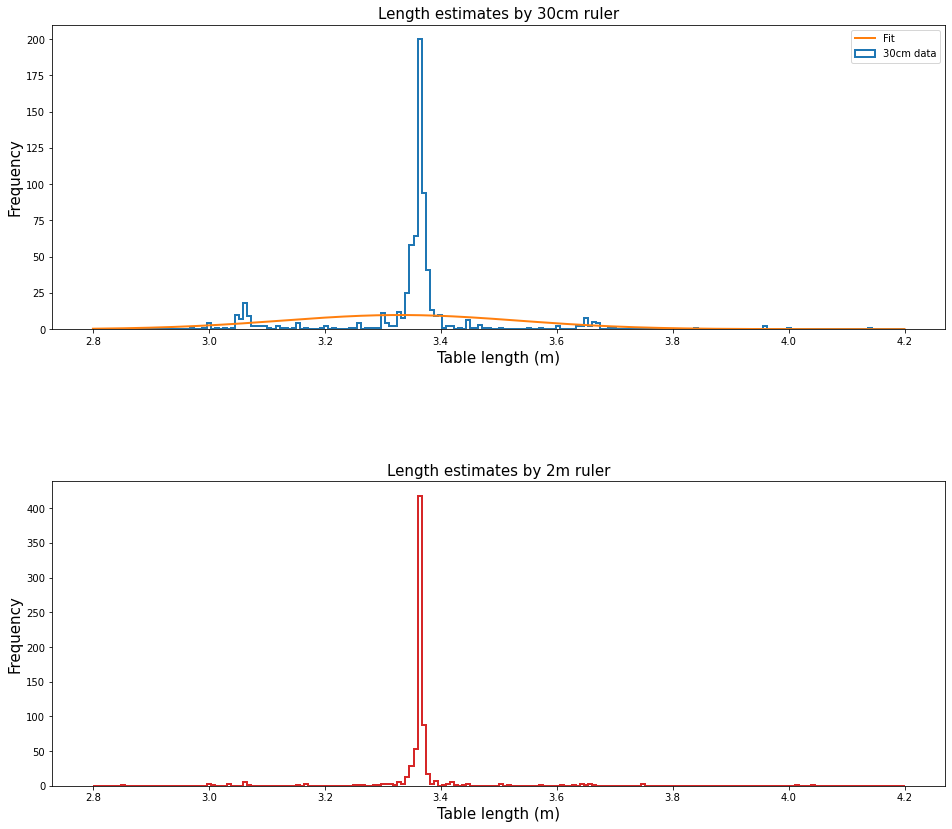

In [14]:
# Create the x-axis for the plot of the fitted function
xaxis = np.linspace(minL, maxL, 1000) 

# Compute the fitted function for x_fit
yaxis = gauss_extended(xaxis, *minuit_L30cm.args) 

# Plot the fitted function
ax_L30cm.plot(xaxis, yaxis, '-', label='Fit', lw=2)
ax_L30cm.legend()

# Show the actual fit and fit results:
fig_raw

### Next steps:

For the above, you should by now be aware, that there is definitely room for improvement. It is now up to you to select in (based on solid **quantified** arguments) and/or correct the data, and subsequently produce a better estimate of the length of the table in world famous Auditorium A. Good luck...

In [15]:
# Clean up in the data:
L30cm = np.sort(L30cm)

# For your data analysis, you can consider either throwing away measurements or correcting them.
# This is question 2 below.
mask = (L30cm>=np.percentile(L30cm,0))*(L30cm<=np.percentile(L30cm,100))      # Write your own data selection!!!

# But remember, you should be able to argue for each an every point you remove or correct!!!
# Barlow 4.2.3 (and the note above this very short section) along with Chauvenet's Criterion might serve as guidelines

L30cm_subset = L30cm[mask]
print(f"  The number of measurements used before and after is: {len(L30cm):d} and {len(L30cm_subset):d}")

  The number of measurements used before and after is: 711 and 711


***

Start by taking a close look at the data, first by inspecting the numbers in the data file (yeps, open the damn thing, and look over the numbers!), and then by considering the histograms produced by running the notebook. To begin with, only consider the 30cm ruler measurements, and disregard the estimated/guessed uncertainties. You can then expand from there, as guided below by questions.

When you're done, please fill in your results here: https://docs.google.com/forms/d/1cqql58JThj7O2O3cKxaRyCe5zRJ0UWv5VllbL0nn8Us/ (anonymous). The purpose is to see, how large variation one can get in answers, even when asking the same data the same questions.


# Questions:

**See example code for several questions below this text (but remember that there are many possible ways to do this!)**

1. Consider the mean, standard deviation, and uncertainty on the mean. Is the result as you would expect it? And do you think that it is close to the best possible (i.e. most accurate and precise) estimate? NOTE: Make sure that you know the difference between accuracy and precision!!! See "Common definition" in: http://en.wikipedia.org/wiki/Accuracy_and_precision

_Example solution 1_: Very much not precise enough. (precision of 20 cm, we can do better!)

2. Do any of the measurements looks wrong/bad/suspicious? Do you see any repeated mistakes done for obvious reasons? Would you correct or exclude any of the measurements and how would you justify this? This problem requires that you discuss with your peers, and then each do what you think most justified/best. It somehow boils down to how far away a measurement is from the expectation.
Apply the criterion you find fitting to the list of measurements, and perhaps produce a new list with your accepted and possibly corrected measurements in (to save the original data). How many measurements did you throw away in the end?

_Example solution 2_: There are little peaks at +30, -30 cm due to measurement mistakes. You can exclude them, correct them (add 30 cm), or fit multiple Gaussians and take into account the highest peak for the table length. You can take for example 3.5 sigma as a limit (since we expect 0.4 data points there) and discard everything outside of that interval. This deletes about half of the data points.

3. Fit your accepted length measurements with a Gaussian distribution, possibly in a (small?) range around what you believe is the true value. What would be your strategy for choosing a range? Is the Gaussian distribution justified? Also, do you see any "human" effects? Did any of your class mates (or you?) not read to mm precision and rounded the result?

_Example solution 3_: Fitting with multiple Gaussians (or a Gaussian in a smaller range) gives a much better result. The histogram is not perfectly Gaussian, there are higher peaks for every zeroth mm, coming from people who rounded their estimate. The p-values for my Gaussian fits are not good, indicating that it might not be similar enough to a Gaussian.

4. Once you have selected the measurements you want to use, calculate the mean, RMS and uncertainty on the mean. How much did your result improve in precision from the raw data in Q1?

_Example solution 4_: Using the tripple peak method: mean = 3.366 +/- 0.00040 and RMS = 0.003 +/- 0.00042. The improved precision in the RMS is 0.203/0.003 = a factor of 68. You would need 4624 measurements to improve that much!

5. The "Pull" distribution is defined as the plot of $z_i = \left(x_i - \mu \right)/\sigma_i$ where $\mu$ is the *sample* mean of $x$, and $x_i$ and $\sigma_i$ are the *single measurements* and their corresponding uncertainties. If the measurements and uncertainties are good, then it should give a unit Gaussian. Is that the case? And thus, were the uncertainty estimates/guesses reasonable? If not, then the pull distribution is often used to remove overly precise measurements (those far out on the tails), and afterwards to scale the errors on the remaining measurements to a reasonable level. Consider the pull distribution, and see if any measurements have suspicious uncertainties.

_Example solution 5_: The pull distribution does not look very Gaussian. It is slightly assymetric, and there are many measurements that are a high number of sigma away from the mean. The Gaussian fit gives mu = 1.7 and sigma = 1.8, but this is a poor fit to the distribution. There are too many pull values very close to zero, indicating that people's uncertainty estimates were too large. But there are also too many outliers - people that measured wrongly and have uncertainties that are too small to reflect that.

6. Try to calculate the weighted mean. Did you get a good Chi2 probability, when doing so? Do you need to discard more dubious measurements? Did the result improve further in precision?

_Example solution 6_: When calculating the weighted mean with all the data points, the $\chi^2$ is quite bad. When discarding the points outside of 3 sigma the result is a lot better: 3.345 +/-  0.001 with a probability of 0.58.

7. Is the number of mismeasurements 30cm below the actual length more common than those 30cm above? Determine the ratio $r_{mis} = N_{30cm~high} / N_{30cm~low}$ including both its statistical uncertainty, and if possible a systematic uncertainty from defining exactly when a measurement is 30cm off.

_Example solution 7_: Pick a range within which you count measurements as too high or too low. Count the number of measurements that belong to each group; $N_{low}$ and $N_{high}$. The error on these counts is calculated by poissonian statistics: $\sqrt{N_{low}}$ and $\sqrt{N_{high}}$. Calculate the ratio of mismeasurements $r_{mis}$. The corresponding error can be found by propagating the uncertainties of $N_{low}$ and $N_{high}$. The systematic uncertainty is associated with the range you pick in which measurements are classified as mismeasurements. Determine standard deviations for your range (pick for example a tight and a loose range), and see how these uncertainties propagate into the ratio (by counting $N_{low}$ and $N_{high}$ and the corresponding $r_{mis}$, for each range). The variation in $r_{mis}$ shows a standard deviation associated with the systamatic uncertainty.



#### Now repeat the above for the 2m folding rule
...and consider all the questions below as optional problems, where you might just try to solve selected problems.
 
***

8. How much better/worse is the single measurement uncertainty from the 30cm ruler case to the 2m folding rule?

_Example solution 8_: Compare the standard deviations from the central peak for the 30cm ruler and the 2m folding ruler case.

9. Does the length of the table seems to be different when measured with a 30cm and a 2m ruler? Quantify this statement! I.e. what is the difference, and what is the uncertainty on that difference? Is this significantly away from 0?

_Example solution 9_: Difference: abs(L30cm_weigthed_mean - L2m_weighted_mean). Uncertainty on difference: propagate errors of the weigthed means into the difference.

Difference in number of sigmas: abs(L30cm_weigthed_mean - L2m_weighted_mean)/sqrt(eL30cm_weigthed_mean^2 + L2m_weighted_mean^2). See how far away this is from zero sigma.

10. If you were asked for the best estimate of the length of the table, what would you do? (If posssible, read Bevington page 58 bottom!)

_Example solution 10_: I would probably take the weighted mean (after discarding the outliers) of the 2m ruler.


### Advanced questions:

11. Consider the 2020 data files with additional information about which day the measurements were done, and find out if the day has an impact on the quality of the measurements.

12. Is there any correlation between the errors on the measurements and the distance value? I.e. do you see any effect of those measuring e.g. too long having a smaller/larger uncertainty? What would the effect of this be?

_Example solution 12_: See if there is a shift in value from the unweighted mean to the weighted mean. If the weighted mean is larger, then people with smaller uncertainties contributed slightly longer measurements of the table.

We expect 32.4 data points to lie outside of 2 sigma,
We expect 1.9 data points to lie outside of 3 sigma,
We expect 0.4 data points to lie outside of 3.5 sigma,
 
Maximum outlier:  265 sigma away from mean!!
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 245.4                      │        Nfcn = 134 (134 total)        │
│ EDM = 2.13e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
 
Gaussian mean: 1.667 and sigm

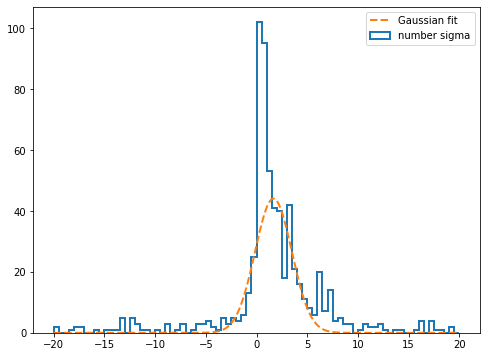

In [16]:
# How many measurements can you discard? 
# If the distribution is Gaussian, you would expect 95.45% to lie within 2 sigma away from the mean,
# and 99.73 % within 3 sigma. For our data set:

print(f"We expect {(len(L30cm)*(1-0.9545)):.1f} data points to lie outside of 2 sigma,")
print(f"We expect {(len(L30cm)*(1-0.9973)):.1f} data points to lie outside of 3 sigma,")
print(f"We expect {(len(L30cm)*(1-0.9995)):.1f} data points to lie outside of 3.5 sigma,")
print(" ")

confidence = (L30cm - L30cm.mean()) / eL30cm
print(f"Maximum outlier: {max(np.abs(confidence)): .0f} sigma away from mean!!")

# plot this distribution and see if it's Gaussian:
fig2, ax2 = plt.subplots(nrows=1, figsize=(8,6))
hist_confidence = ax2.hist(confidence, bins=80, range=(-20, 20), histtype='step', lw=2, label='number sigma')

# Fit a Gaussian to it 
y, ends, _ = hist_confidence
x = (ends[1:] + ends[:-1])/2
sy = np.sqrt(y)
chi2fit0 = Chi2Regression(gauss_extended, x[y>0], y[y>0], sy[y>0])
minuit0 = Minuit(chi2fit0, pedantic=False, N=100, mu=0, sigma=3, print_level=1) 
minuit0.migrad();

Mu = minuit0.values["mu"]
Sigma = minuit0.values["sigma"]
print(" ")
print(f"Gaussian mean: {Mu:.3f} and sigma: {Sigma:.3f}")

# Calculate probability of the fit
Ndof_bin = len(x[y>0]) - 3     
Prob_bin = stats.chi2.sf(minuit0.fval, Ndof_bin)
print(f"Chi2 = {minuit0.fval: .2f}, probability = {Prob_bin: .2f}")

# Plot this fit

# Compute the fitted function for x_fit
xaxis0 = np.linspace(-20, 20, 1000)
yaxis0 = gauss_extended(xaxis0, *minuit0.args) 

# Plot the fitted function
ax2.plot(xaxis0, yaxis0, '--', label='Gaussian fit', lw=2)
ax2.legend()



Data points remaining:  405
New mean:  3.356 +/-  0.054 
Data points remaining:  587
New mean:  3.362 +/-  0.030 


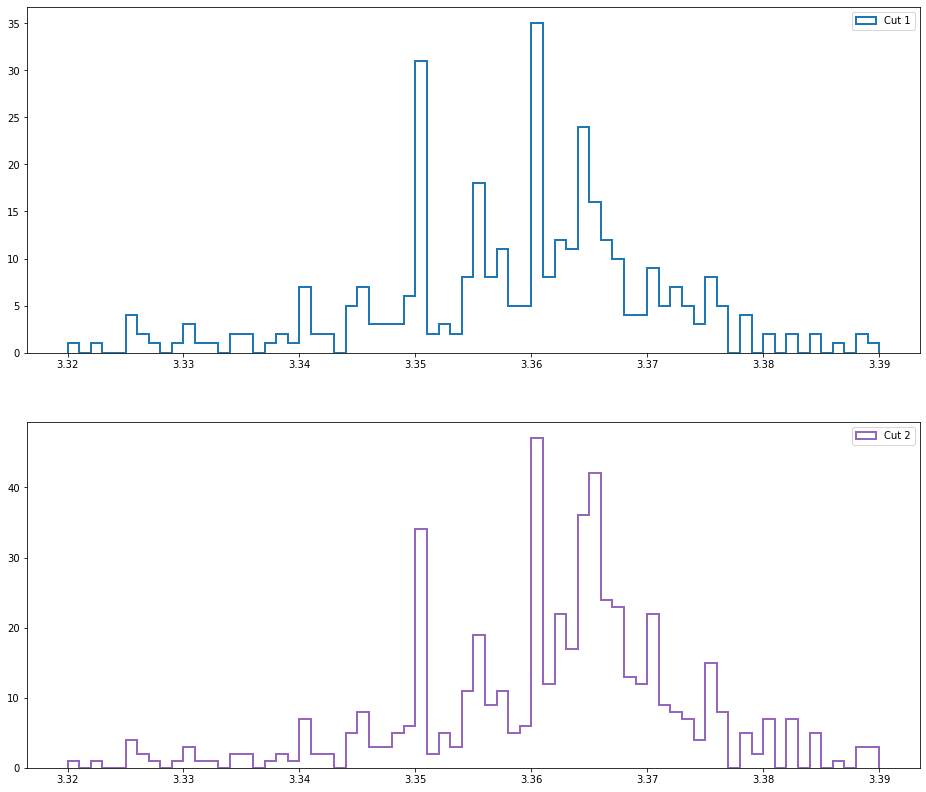

In [17]:
# Start removing data points

# By removing all data points that are more than [sigma_limit] sigma away from the mean
sigma_limit = 3
L30cm_cut1 = L30cm[abs(confidence) < sigma_limit]
eL30cm_cut1 = eL30cm[abs(confidence) < sigma_limit]
print("Data points remaining: ", len(L30cm_cut1))
print(f"New mean: {L30cm_cut1.mean(): .3f} +/- {L30cm_cut1.std(): .3f} ")

# By removing all data points that are not between 3.2 and 3.6
L30cm_cut2 = L30cm[(L30cm > 3.2) & (L30cm < 3.6)]
print("Data points remaining: ", len(L30cm_cut2))
print(f"New mean: {L30cm_cut2.mean(): .3f} +/- {L30cm_cut2.std(): .3f} ")
        
# plot this new distribution:
fig3, ax3 = plt.subplots(nrows=2, figsize=(16,14))
hist_confidence = ax3[0].hist(L30cm_cut1, bins=70, range=(3.32, 3.39), histtype='step', lw=2, label='Cut 1')
hist_confidence = ax3[1].hist(L30cm_cut2, bins=70, range=(3.32, 3.39), histtype='step', lw=2, color="C4", label='Cut 2')
import matplotlib.ticker as ticker
ax3[0].xaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax3[0].legend()
ax3[1].legend()
#print(L30cm_cut)


In [18]:
# Weighted mean calculation

print("- - - Considering all data points: - - - ")
w_mean = sum(L30cm / (eL30cm)**2) / sum(1 / (eL30cm)**2)
e_w_mean = (sum(1 / eL30cm**2))**(-0.5)
print(f"Weighted mean =  {w_mean: .3f} +/- {e_w_mean: .3f}")

chi2_w30 = sum(np.square((L30cm - w_mean) / eL30cm))
print(f"Chi2 = {chi2_w30:.0f}")
print("Ndof = ", len(L30cm)-1)
Prob = stats.chi2.sf(chi2_w30, len(L30cm)-1)
print("P-value = ", Prob)

print(" ")
print(f"- - - Considering data points inside{sigma_limit: .1f} sigma: - - - ")

w_mean_cut1 = sum(L30cm_cut1 / (eL30cm_cut1)**2) / sum(1 / (eL30cm_cut1)**2)
e_w_mean_cut1 = (sum(1 / eL30cm_cut1**2))**(-0.5)
print(f"Weighted mean =  {w_mean_cut1: .3f} +/- {e_w_mean_cut1: .3f}")

chi2_w30_cut1 = sum(np.square((L30cm_cut1 - w_mean_cut1) / eL30cm_cut1))
print(f"Chi2 = {chi2_w30_cut1:.0f}")
print("Ndof = ", len(L30cm_cut1)-1)
Prob_cut1 = stats.chi2.sf(chi2_w30_cut1, len(L30cm_cut1)-1)
print(f"P-value = {Prob_cut1:.5f}")


- - - Considering all data points: - - - 
Weighted mean =   3.344 +/-  0.000
Chi2 = 435279
Ndof =  710
P-value =  0.0
 
- - - Considering data points inside 3.0 sigma: - - - 
Weighted mean =   3.345 +/-  0.001
Chi2 = 398
Ndof =  404
P-value = 0.57920


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 143.7                      │        Nfcn = 659 (659 total)        │
│ EDM = 5.23e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
<ValueView of Minuit at 7fee0d421da8>
  N1: 3.088424562262549
  mu1: 3.3631107880685454
  sigma1: 0.010635696497382064
  N2: 3.469128189237267
  mu2: 3.3232944745909765
  sigma2: 0.8975706051657222
 
Main peak: 3.363, RMS: 0.011
Chi2 =  143

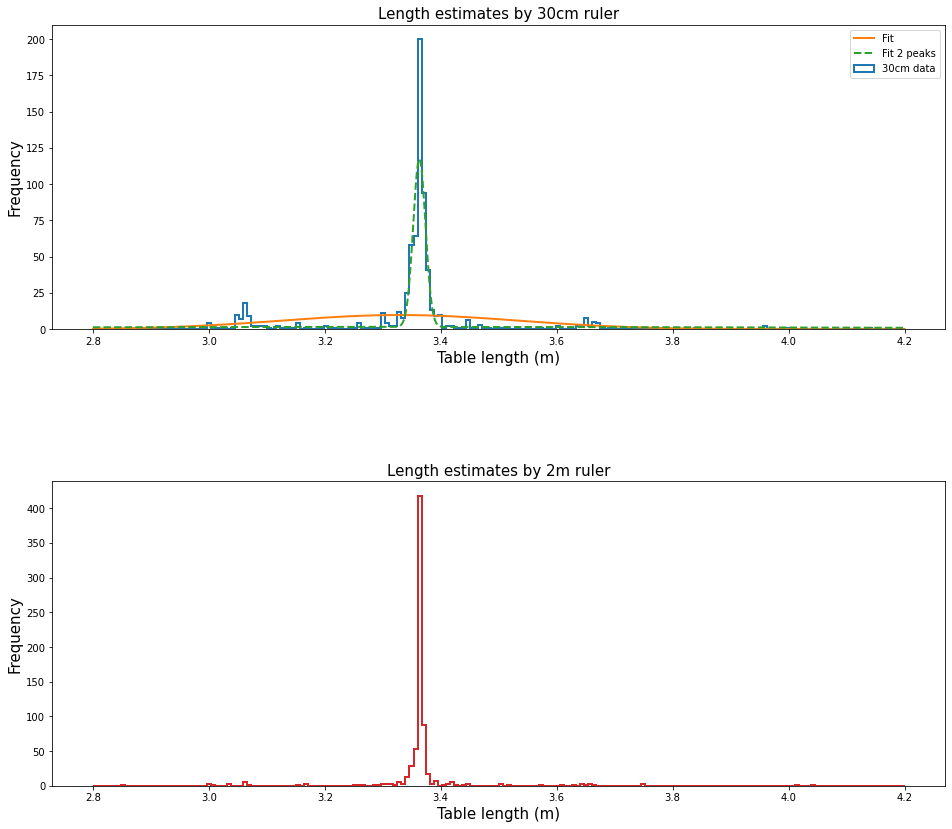

In [19]:
# Now, try fitting a Gaussian with 2 peaks!

norm = len(L30cm)*binwidth

y, ends, _ = hist_L30cm
x = (ends[1:] + ends[:-1])/2
sy = np.sqrt(y)
chi2fit = Chi2Regression(gauss_2, x[y>0], y[y>0], sy[y>0])
minuit2 = Minuit(chi2fit, pedantic=False, N1 = norm, N2 = norm, mu1=L30cm.mean()+0.05,
                 mu2=L30cm.mean()-0.3, sigma1=0.01,
                 sigma2=0.01, print_level=1) 
minuit2.migrad();
print(minuit2.values)
Mu = minuit2.values["mu1"]
Sigma = minuit2.values["sigma1"]
print(" ")
print(f"Main peak: {Mu:.3f}, RMS: {Sigma:.3f}")

# Calculate probability of the fit
Ndof_bin = len(x[y>0]) - 6     
Prob_bin = stats.chi2.sf(minuit2.fval, Ndof_bin)
print(f"Chi2 = {minuit2.fval: .2f}, probability = {Prob_bin: .2f}")

# Plot this fit

# Compute the fitted function for x_fit
yaxis2 = gauss_2(xaxis, *minuit2.args) 

# Plot the fitted function
ax_L30cm.plot(xaxis, yaxis2, '--', label='Fit 2 peaks', lw=2)
ax_L30cm.legend()

# Show the actual fit and fit results:
fig_raw

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 141.9                      │       Nfcn = 1505 (1505 total)       │
│ EDM = 2.11 (Goal: 0.0002)        │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
<ValueView of Minuit at 7fee1d567108>
  N1: 0.8738340468589622
  mu1: 3.365602803859837
  sigma1: 0.002786691739750257
  N2: 0.27554809872173164
  mu2: 3.06058033445854
  sigma2: 0.009014540356234257
  N3: 2.635069723657585
  mu3: 3.3619129

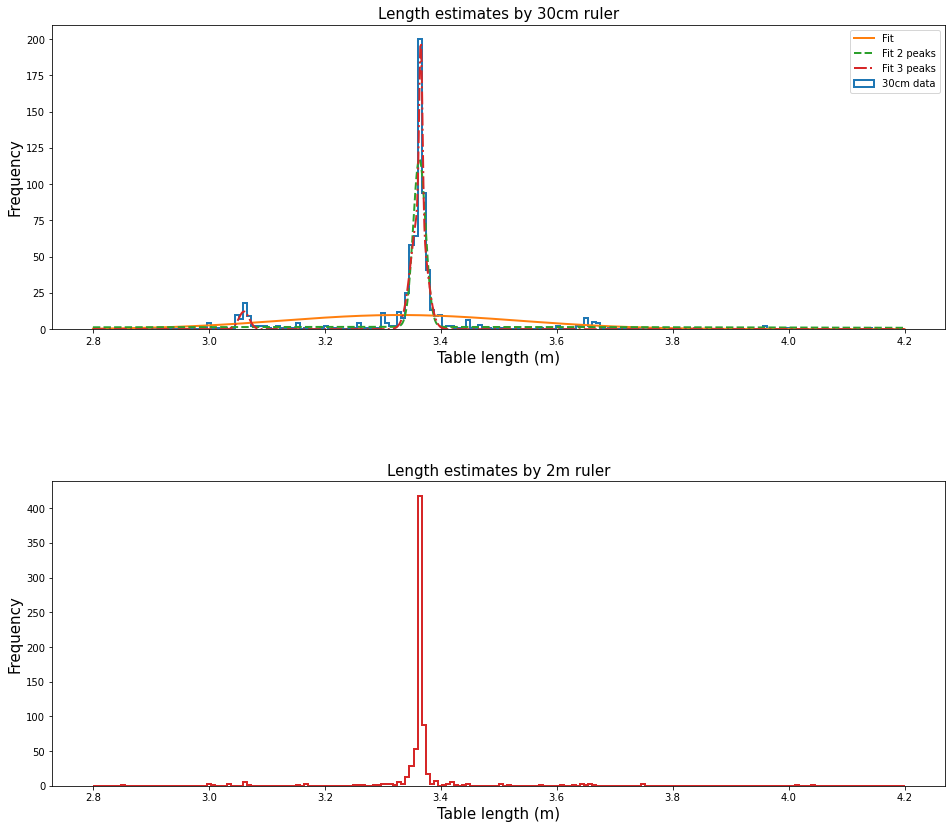

In [20]:
# Now, try fitting a Gaussian with 3 peaks!

chi2fit3 = Chi2Regression(gauss_3, x[y>0], y[y>0], sy[y>0])
minuit3 = Minuit(chi2fit3, pedantic=False, N1 = norm, N2 = norm/4, N3=norm/5, mu1=L30cm.mean(),
                 mu2=L30cm.mean()-0.3, mu3=L30cm.mean()+0.3, sigma1=0.01, sigma3=0.01,
                 sigma2=0.01, print_level=1) 
minuit3.migrad();

print(minuit3.values)
Mu = minuit3.values["mu1"]
eMu = minuit3.errors["mu1"]
Sigma = minuit3.values["sigma1"]
eSigma = minuit3.errors["sigma1"]
print(" ")
print(f"Main peak: {Mu:.3f} +/- {eMu: .5f}, RMS = {Sigma:.3f} +/- {eSigma: .5f}")

# Calculate probability of the fit
Ndof_bin = len(x[y>0]) - 6     
Prob_bin = stats.chi2.sf(minuit3.fval, Ndof_bin)
print(f"Chi2 = {minuit3.fval: .2f}, probability = {Prob_bin: .2f}")

# Plot this fit

# Compute the fitted function for x_fit
yaxis3 = gauss_3(xaxis, *minuit3.args) 

# Plot the fitted function
ax_L30cm.plot(xaxis, yaxis3, '-.', label='Fit 3 peaks', lw=2)
ax_L30cm.legend()

# Show the actual fit and fit results:
fig_raw